In [1045]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "26" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 117
repetitionName = "2cOnlySepOnlyCurr05th"#"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = True
if saveTop:
    saveTopName = "top3udi.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)


36
4.0


In [1046]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])
#print(combinationDict)
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
                print(ares)
                aC = aResults2[3]
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]

    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

# timesPerCombo = timesPerCombo/len(savedResults)

# combinationResult[:,:,1] = combinationResult[:,:,1] / timesPerCombo


headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            # if res[1]>0.99:
            #     print(res[1])
            #     res[1] = res[1] / 2
            #     print(res[1])
                
            # print(res[0])
            cmbNr = int(res[0])
            # print(cmbNr)
            #print(cmbNr)
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            # print(comboName)
            #print(nameIndex)
            #print(featCombos[nameIndex])
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




0.5833333333333334
0.5
0.5416666666666666
0.375
0.4166666666666667
0.4166666666666667
0.75
0.7083333333333334
0.7083333333333334
0.4583333333333333
0.6666666666666666
0.5
0.4583333333333333
0.5833333333333334
0.4583333333333333
0.5416666666666666
0.7083333333333334
0.625
0.2916666666666667
0.4166666666666667
0.3333333333333333
0.4583333333333333
0.5
0.5
0.5
0.4583333333333333
0.5833333333333334
0.5
0.5
0.5
0.4166666666666667
0.4583333333333333
0.5
0.375
0.375
0.4583333333333333
0.5416666666666666
0.5416666666666666
0.5833333333333334
0.6666666666666666
0.625
0.5416666666666666
0.625
0.5833333333333334
0.625
0.5833333333333334
0.625
0.5416666666666666
0.5
0.4583333333333333
0.5416666666666666
0.4583333333333333
0.4166666666666667
0.5
0.625
0.5833333333333334
0.5
0.5
0.5
0.5
0.5416666666666666
0.5833333333333334
0.625
0.5
0.4166666666666667
0.4166666666666667
0.3333333333333333
0.5
0.4166666666666667
0.4166666666666667
0.3333333333333333
0.5
0.5
0.5
0.5416666666666666
0.5833333333333334


0         1         2         3         4         5         6     \
0       0.0      None      None      None      None      None      None   
1       0.5    0.5125       0.5    0.4375    0.4375     0.425    0.3875   
2  0.552083  0.520833  0.583333   0.53125  0.520833       0.5  0.520833   
3  0.638889  0.583333  0.638889  0.472222  0.541667  0.611111  0.541667   
4  0.427083       0.5   0.46875   0.40625  0.510417  0.447917  0.427083   
5  0.583333  0.552083   0.65625    0.5625  0.541667  0.510417  0.520833   
6  0.488636  0.556818  0.477273  0.443182  0.534091  0.431818  0.545455   
7   0.46875       0.5   0.46875  0.385417  0.395833  0.427083   0.53125   
8    0.5625      0.55     0.575    0.6375    0.5375      0.65     0.475   
9  0.552083  0.520833  0.572917   0.53125    0.4375  0.510417  0.520833   

       7         8         9         10        11        12        13    \
0      None      None      None      None      None      None      None   
1    0.4625    0.4125      0.55      0.55    0.5125    0.5125      0.45   
2       0.5  0.541667  0.447917   0.46875  0.447917  0.510417  0.489583   
3  0.638889       0.5  0.541667  0.666667       0.5  0.430556  0.486111   
4  0.395833  0.427083       0.5  0.489583       0.5  0.489583   0.46875   
5   0.40625  0.520833  0.677083    0.5625   0.71875  0.520833   0.46875   
6  0.613636  0.534091  0.556818  0.534091  0.534091  0.443182  0.386364   
7       0.5  0.552083    0.5625  0.520833   0.59375   0.46875  0.458333   
8    0.4375      0.45    0.3875       0.4    0.4625    0.6375    0.6875   
9       0.5  0.583333       0.5  0.458333  0.427083  0.552083       0.5   

       14        15        16        17        18        19        20    \
0      None      None      None      None      None      None      None   
1     0.425    0.4125    0.4875    0.4875      0.45    0.4125    0.4375   
2       0.5  0.479167  0.510417  0.604167    0.4375    0.4375  0.364583   
3  0.416667  0.444444  0.444444  0.555556  0.555556  0.569444  0.472222   
4   0.53125  0.479167   0.53125  0.489583  0.427083   0.53125   0.46875   
5    0.5625  0.447917   0.53125   0.59375  0.447917  0.427083  0.479167   
6  0.420455  0.454545  0.488636  0.556818  0.545455  0.545455  0.579545   
7  0.510417  0.520833    0.5625     0.625  0.364583  0.364583  0.395833   
8    0.5625    0.6375     0.575    0.6625    0.6125     0.625      0.55   
9  0.541667  0.645833  0.447917  0.541667  0.479167   0.46875  0.416667   

       21        22        23        24        25        26        27    \
0      None      None      None      None      None      None      None   
1    0.5625    0.5875     0.575    0.4375    0.4125    0.4125    0.4125   
2  0.458333  0.354167  0.479167  0.489583  0.520833  0.520833  0.510417   
3  0.472222       0.5  0.444444  0.513889  0.583333  0.541667  0.416667   
4  0.458333  0.614583  0.479167  0.541667  0.520833  0.541667  0.479167   
5  0.427083  0.416667   0.40625  0.520833    0.4375    0.4375  0.666667   
6  0.579545  0.602273  0.556818  0.556818  0.636364  0.556818     0.625   
7   0.53125  0.541667  0.541667   0.53125   0.59375  0.510417  0.541667   
8      0.55    0.5375      0.45    0.6375    0.5875    0.6125    0.5625   
9   0.53125  0.552083  0.572917   0.53125  0.489583   0.53125    0.5625   

       28        29        30        31        32        33        34    \
0      None      None      None      None      None      None      None   
1    0.4625    0.4875    0.6125      0.55    0.5375      0.45      0.45   
2  0.510417   0.53125  0.479167  0.427083  0.458333  0.395833  0.447917   
3  0.444444  0.444444  0.583333  0.541667  0.583333       0.5  0.513889   
4  0.489583   0.46875       0.5  0.520833  0.479167  0.479167  0.489583   
5  0.572917  0.583333  0.510417   0.53125  0.552083  0.572917  0.520833   
6  0.602273  0.579545  0.454545       0.5  0.397727  0.477273  0.477273   
7  0.520833    0.5625  0.541667  0.572917  0.552083  0.354167    0.4375   
8    0.5375      0.55    0.5

In [1047]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


fftData_BCpeakTime4SortedSep13  hilbertData_BCpeakTime4SortedSep13  \
0                        0.000000                            0.000000   
1                        0.512500                            0.437500   
2                        0.583333                            0.531250   
3                        0.638889                            0.611111   
4                        0.500000                            0.510417   
5                        0.656250                            0.562500   
6                        0.556818                            0.534091   
7                        0.500000                            0.427083   
8                        0.575000                            0.650000   
9                        0.572917                            0.531250   

   fftData_BC_CVpeakTime4SortedSep13  hilbertData_BC_CVpeakTime4SortedSep13  \
0                           0.000000                               0.000000   
1                           0.462500                               0.550000   
2                           0.541667                               0.468750   
3                           0.638889                               0.666667   
4                           0.427083                               0.500000   
5                           0.520833                               0.718750   
6                           0.613636                               0.556818   
7                           0.552083                               0.593750   
8                           0.475000                               0.462500   
9                           0.583333                               0.500000   

   gausData_CV_BCpeakTime4SortedSep13  gausData_BCpeakTime4SortedSep13  \
0                            0.000000                         0.000000   
1                            0.512500                         0.487500   
2                            0.510417                         0.604167   
3                            0.486111                         0.555556   
4                            0.531250                         0.531250   
5                            0.562500                         0.593750   
6                            0.443182                         0.556818   
7                            0.510417                         0.625000   
8                            0.687500                         0.662500   
9                            0.552083                         0.645833   

   gausData_BC_CVpeakTime4SortedSep13  fftData_BC_ifftpeakTime4SortedSep13  \
0                            0.000000                             0.000000   
1                            0.450000                             0.587500   
2                            0.437500                             0.479167   
3                            0.569444                             0.500000   
4                            0.531250                             0.614583   
5                            0.479167                             0.427083   
6                            0.579545                             0.602273   
7                            0.395833                             0.541667   
8                            0.625000                             0.550000   
9                            0.479167                             0.572917   

   fftData_BC_ifft_CVpeakTime4SortedSep13  stftDatapeakTime4SortedSep13  \
0                                0.000000                      0.000000   
1                                0.437500                      0.487500   
2                                0.520833                      0.531250   
3                                0.583333                      0.444444   
4                                0.541667                      0.489583   
5                                0.520833                      0.666667   
6                                0.636364                      0.625000   
7                                0.593750              

In [1048]:
for x in timesPerCombo:
    print(x)

36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0
36.0


(990,)




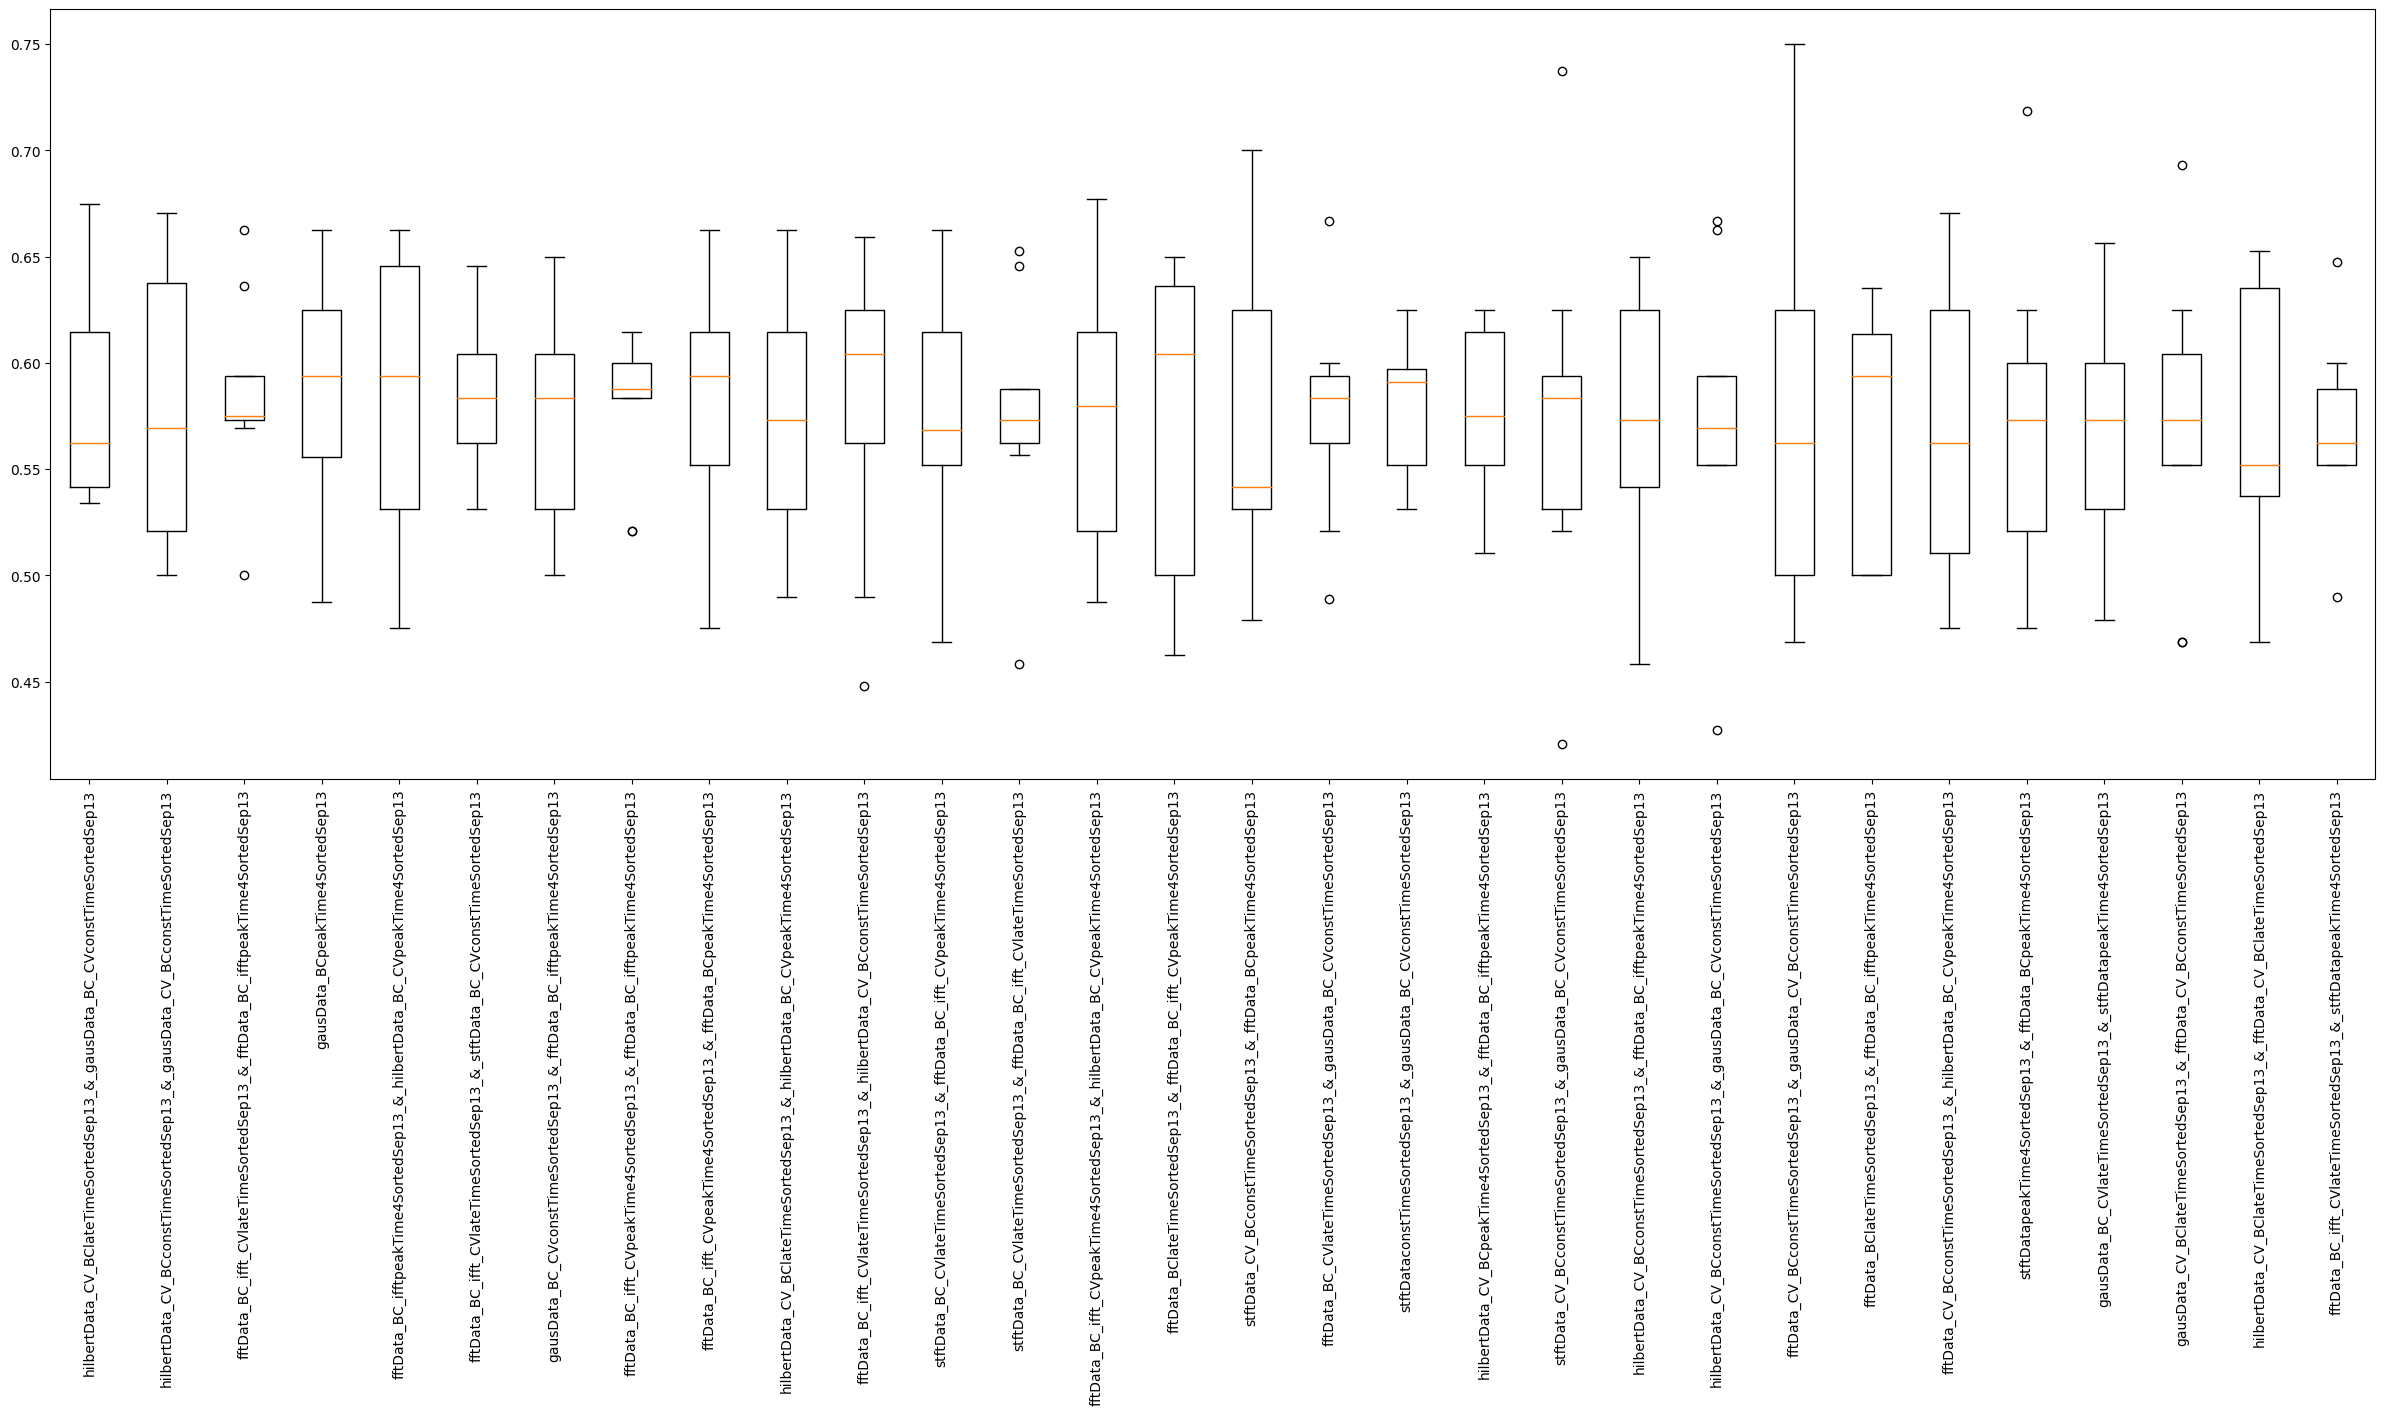

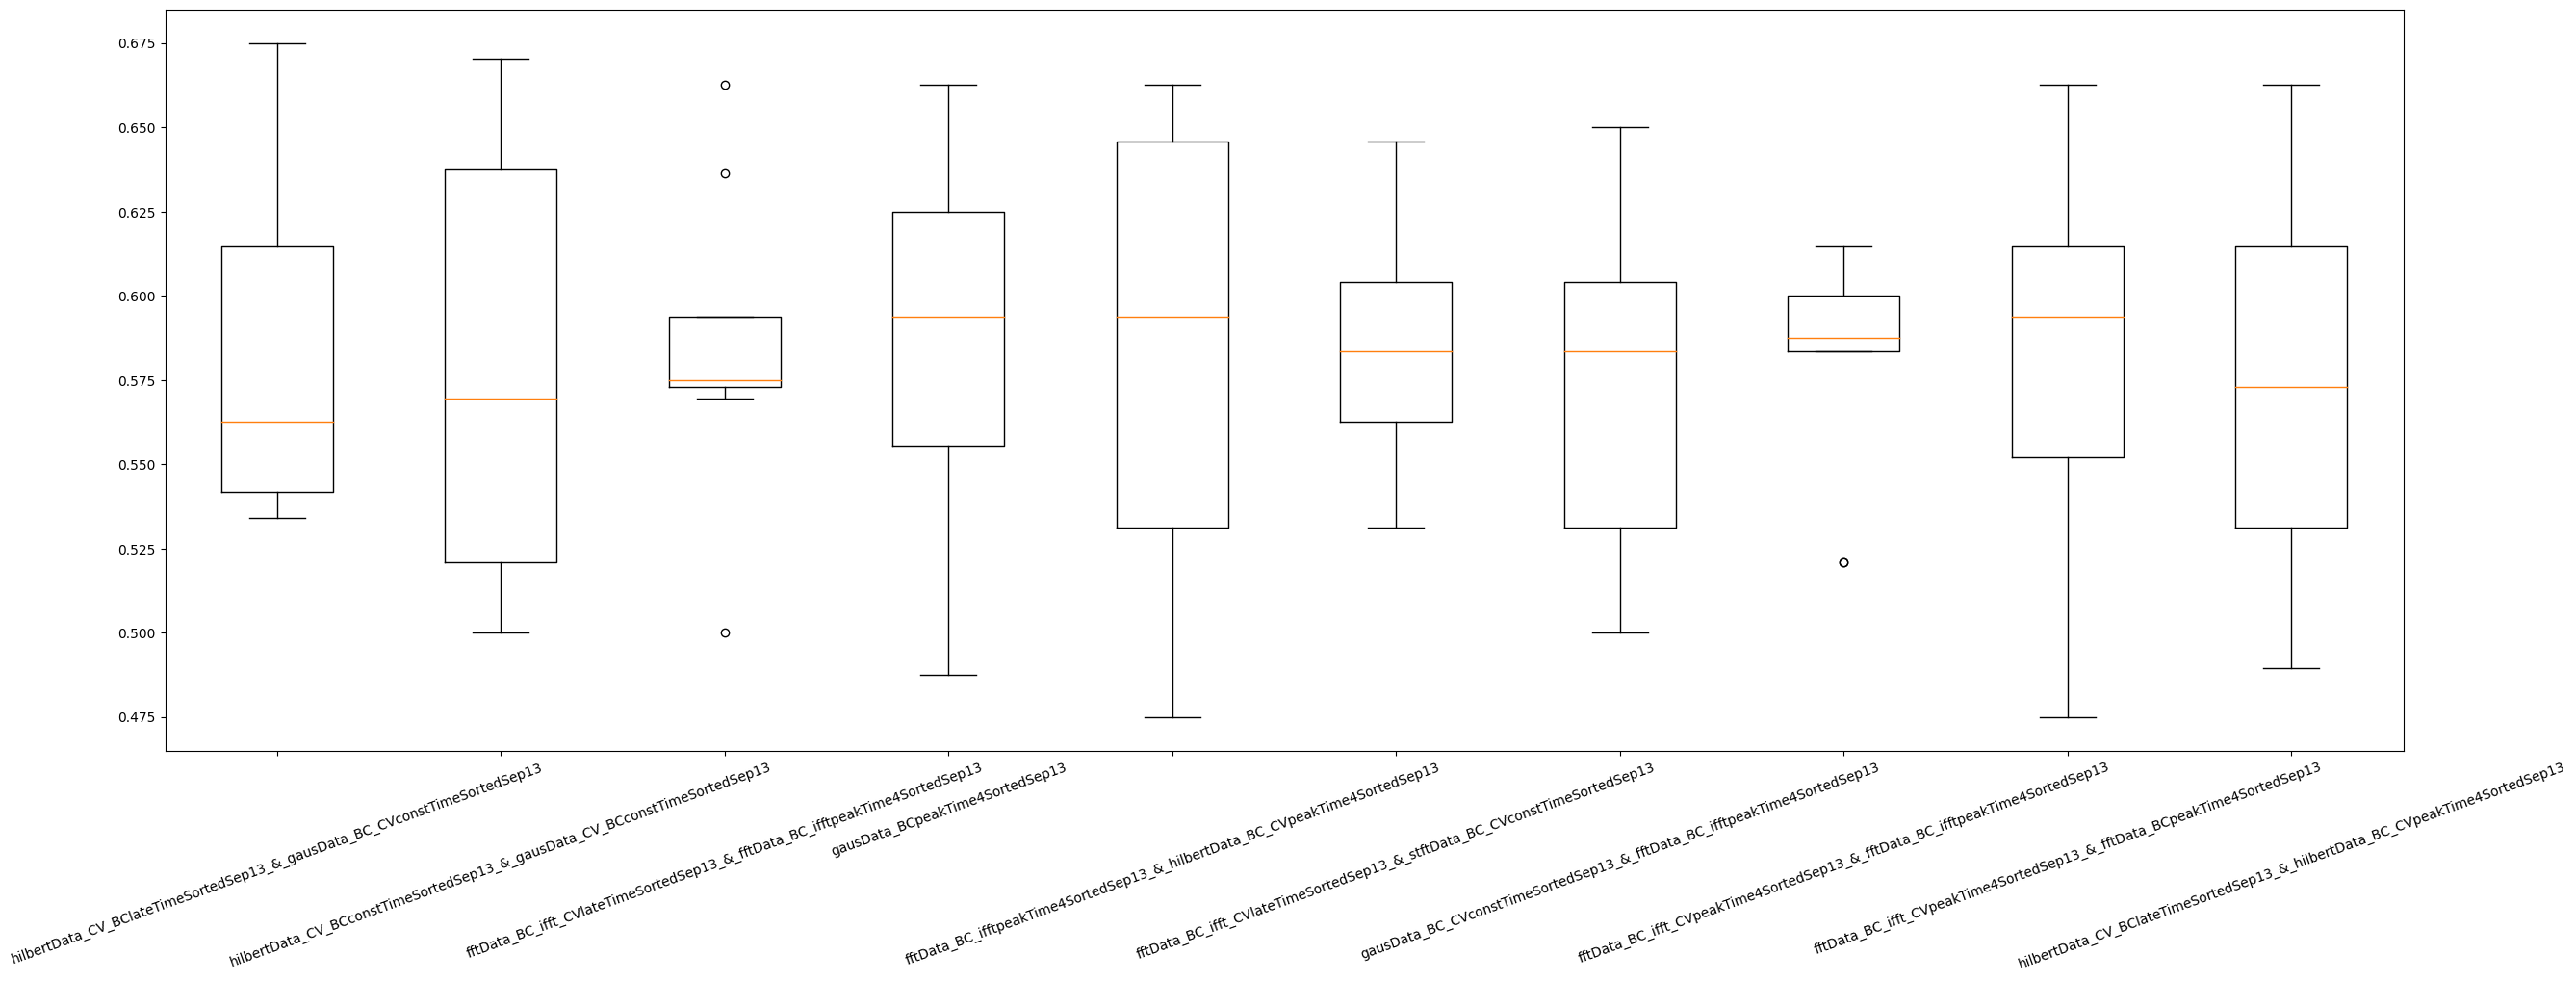

In [1049]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [1050]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.78 : subject 3, feature:stftData_BC_CVconstTimeSortedSep13_&_stftDataconstTimeSortedSep13, kernellinear, C:2.5
Accuracy 0.76 : subject 6, feature:fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_CV_BCconstTimeSortedSep13, kernellinear, C:2.5
Accuracy 0.75 : subject 6, feature:fftData_CV_BCconstTimeSortedSep13_&_gausData_CV_BCconstTimeSortedSep13, kernelsigmoid, C:2.5
Accuracy 0.75 : subject 6, feature:fftData_CV_BCconstTimeSortedSep13_&_stftDataconstTimeSortedSep13, kernellinear, C:2.5
Accuracy 0.74 : subject 8, feature:stftDatalateTimeSortedSep13_&_stftData_CV_BCconstTimeSortedSep13, kernellinear, C:2.5
Accuracy 0.74 : subject 8, feature:stftData_CV_BCconstTimeSortedSep13_&_gausData_BC_CVconstTimeSortedSep13, kernelsigmoid, C:2.5
Accuracy 0.73 : subject 8, feature:stftData_CV_BCconstTimeSortedSep13_&_stftDatapeakTime4SortedSep13, kernelsigmoid, C:2.5
Accuracy 0.72 : subject 8, feature:stftDatalateTimeSortedSep13_&_stftData_CV_BCconstTimeSortedSep13

In [1051]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [1052]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < 2:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.78 : subject 3, feature:stftData_BC_CVconstTimeSortedSep13_&_stftDataconstTimeSortedSep13, kernellinear, C:2.5

Accuracy 0.76 : subject 6, feature:fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_CV_BCconstTimeSortedSep13, kernellinear, C:2.5

Accuracy 0.74 : subject 8, feature:stftDatalateTimeSortedSep13_&_stftData_CV_BCconstTimeSortedSep13, kernellinear, C:2.5

Accuracy 0.72 : subject 5, feature:stftDatapeakTime4SortedSep13_&_fftData_BCpeakTime4SortedSep13, kernellinear, C:2.5

Accuracy 0.7 : subject 1, feature:fftData_CV_BClateTimeSortedSep13_&_fftData_BC_ifftpeakTime4SortedSep13, kernelsigmoid, C:2.5

Accuracy 0.7 : subject 9, feature:gausData_BC_CVlateTimeSortedSep13_&_stftData_CV_BCpeakTime4SortedSep13, kernelsigmoid, C:2.5

Accuracy 0.69 : subject 2, feature:fftData_BC_ifft_CVlateTimeSortedSep13_&_hilbertData_BC_CVconstTimeSortedSep13, kernelsigmoid, C:2.5

Accuracy 0.68 : subject 7, feature:fftData_BC_ifft_CVlateTimeSortedSep13_&_hilbertData_BC_CVconstTimeSortedSep13

In [1053]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.49553451 0.47176627 0.53603161 0.49718715 0.49653479
 0.51205999 0.48878718 0.51678872 0.5120686 ]


0         1         2         3         4         5         6     \
0  0.001602  0.532934  0.549018  0.489675  0.495223  0.501529  0.496717   

       7         8         9         10        11        12        13    \
0  0.494957  0.502399  0.524832  0.516751  0.521843  0.507267  0.488377   

       14        15        16        17        18        19        20    \
0  0.496717  0.502434  0.508768  0.568504  0.479973  0.486841  0.462696   

       21        22        23        24        25       26        27    \
0  0.507835  0.522938  0.500603  0.528921  0.531355  0.51835  0.530787   

       28        29        30        31        32       33        34    \
0  0.522552  0.527666  0.523885  0.519907  0.501599  0.46391  0.489064   

      35        36        37        38        39        40       41    \
0  0.45557  0.472804  0.507625  0.476824  0.517726  0.508586  0.50235   

       42        43        44        45        46       47        48    \
0  0.527609  0.511637  0.516239  0.493259  0.493897  0.48569  0.498092   

       49        50        51        52        53        54       55    \
0  0.495328  0.476606  0.476515  0.531467  0.473681  0.501669  0.50221   

       56        57        58        59       60        61        62    \
0  0.503521  0.501185  0.463461  0.538103  0.51687  0.508958  0.492978   

       63        64        65        66        67        68        69    \
0  0.514155  0.512156  0.530913  0.483193  0.470272  0.489366  0.491884   

       70        71        72       73        74        75        76    \
0  0.489745  0.509463  0.513194  0.50451  0.510031  0.478465  0.478963   

      77        78        79       80        81        82        83    \
0  0.48118  0.524151  0.512191  0.52345  0.519346  0.538889  0.507078   

       84        85        86        87        88        89        90    \
0  0.541512  0.510241  0.539233  0.517684  0.510746  0.538489  0.498513   

       91        92        93        94        95        96        97    \
0  0.512661  0.492347  0.482744  0.483677  0.480955  0.466849  0.481853   

       98        99        100       101       102       103       104   \
0  0.481432  0.492515  0.482548  0.501522  0.533993  0.510473  0.529875   

      105       106       107       108       109       110       111   \
0  0.50921  0.497882  0.491632  0.499123  0.504503  0.476045  0.469999   

       112       113      114      115       116       117       118   \
0  0.496619  0.452224  0.55296  0.51257  0.530008  0.492551  0.477518   

       119       120       121       122       123       124       125   \
0  0.470237  0.464212  0.455542  0.477266  0.519613  0.488279  0.537044   

       126       127       128       129       130       131       132   \
0  0.513735  0.510045  0.529047  0.506201  0.500884  0.505857  0.507106   

      133       134       135       136       137       138       139   \
0  0.53064  0.507912  0.512865  0.496801  0.504005  0.513812  0.528991   

       140       141       142       143       144       145       146   \
0  0.533537  0.505485  0.489569  0.506622  0.527595  0.547243  0.525638   

       147       148       149       150       151       152       153   \
0  0.493189  0.498162  0.481987  0.512346  0.522313  0.516681  0.540383   

       154       155       156       157       158       159    160   \
0  0.548744  0.523092  0.553781  0.538987  0.534407  0.521486  0.509   

       161       162      163       164       165      166       167   \
0  0.521275  0.486034  0.49812  0.480366  0.482064  0.52103  0.492284   

       168       169       170       171       172       173       174   \
0  0.495981  0.509996  0.509456  0.527069  0.512051  0.527427  0.513412   

      175       176       177       178       179       180       181   \
0  0.52164  0.526256  0.497068  0.530015  0.503655  0.509898  0.530626   

      182       183     184      185     186       187       188       189   \
0  0.50094  0.494522  0.5051  0.51135  0.5

Max average accuracy 0.5768027497194164


In [1054]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_BC_ifftpeakTime4SortedSep13
linear
0.5768027497194164

hilbertData_CV_BClateTimeSortedSep13_&_gausData_BC_CVconstTimeSortedSep13
sigmoid
0.5723063973063973

fftData_BC_ifft_CVlateTimeSortedSep13_&_stftData_BC_CVconstTimeSortedSep13
linear
0.5707491582491583

gausData_BCpeakTime4SortedSep13
sigmoid
0.5685044893378227

fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_BC_ifftpeakTime4SortedSep13
sigmoid
0.5683852413019079



In [1055]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_BC_ifftpeakTime4SortedSep13
linear
0.5768027497194164

hilbertData_CV_BClateTimeSortedSep13_&_gausData_BC_CVconstTimeSortedSep13
sigmoid
0.5723063973063973

fftData_BC_ifft_CVlateTimeSortedSep13_&_stftData_BC_CVconstTimeSortedSep13
linear
0.5707491582491583

gausData_BCpeakTime4SortedSep13
sigmoid
0.5685044893378227

fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_BC_ifftpeakTime4SortedSep13
sigmoid
0.5683852413019079



In [1056]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


0         1         2         3         4         5         6     \
0  4.773359  4.796402  4.941162  4.407071  4.457008  4.513763  4.470455   

       7         8         9         10        11        12        13    \
0  4.454609  4.521591  4.723485  4.650758  4.696591  4.565404  4.395391   

       14        15        16       17       18        19        20    \
0  4.470455  4.521907  4.578914  5.11654  4.31976  4.381566  4.164268   

       21        22        23       24        25        26        27    \
0  4.570518  4.706439  4.505429  4.76029  4.782197  4.665152  4.777083   

       28       29        30        31        32        33        34    \
0  4.702967  4.74899  4.714962  4.679167  4.514394  4.175189  4.401578   

       35       36        37        38        39        40        41    \
0  4.100126  4.25524  4.568624  4.291414  4.659533  4.577273  4.521149   

       42        43        44        45        46        47        48    \
0  4.748485  4.604735  4.646149  4.439331  4.445076  4.371212  4.482828   

       49        50        51        52        53        54        55    \
0  4.457955  4.289457  4.288636  4.783207  4.263131  4.515025  4.519886   

       56        57        58        59        60        61        62    \
0  4.531692  4.510669  4.171149  4.842929  4.651831  4.580619  4.436806   

       63        64       65        66        67        68        69    \
0  4.627399  4.609407  4.77822  4.348737  4.232449  4.404293  4.426957   

       70        71       72        73        74        75        76    \
0  4.407702  4.585164  4.61875  4.540593  4.590278  4.306187  4.310669   

       77        78        79        80        81    82        83        84    \
0  4.330619  4.717361  4.609722  4.711048  4.674116  4.85  4.563699  4.873611   

       85        86        87        88        89        90        91    \
0  4.592172  4.853093  4.659154  4.596717  4.846402  4.486616  4.613952   

       92        93        94        95        96        97        98    \
0  4.431124  4.344697  4.353093  4.328598  4.201641  4.336679  4.332891   

       99        100       101       102       103       104       105   \
0  4.432639  4.342929  4.513699  4.805934  4.594255  4.768876  4.582891   

       106       107       108      109       110       111       112   \
0  4.480934  4.424684  4.492109  4.54053  4.284407  4.229987  4.469571   

       113       114       115       116       117       118       119   \
0  4.070013  4.976641  4.613131  4.770076  4.432955  4.297664  4.232134   

       120       121       122       123       124       125       126   \
0  4.177904  4.099874  4.295391  4.676515  4.394508  4.833396  4.623611   

       127       128       129       130       131       132       133   \
0  4.590404  4.761427  4.555808  4.507955  4.552715  4.563952  4.775758   

       134       135       136       137       138       139       140   \
0  4.571212  4.615783  4.471212  4.536048  4.624306  4.760922  4.801831   

       141       142       143       144       145       146       147   \
0  4.549369  4.406124  4.559596  4.748359  4.925189  4.730745  4.438699   

      148       149       150       151       152       153       154   \
0  4.48346  4.337879  4.611111  4.700821  4.650126  4.863447  4.938699   

       155       156       157       158       159       160       161   \
0  4.707828  4.984028  4.850884  4.809659  4.693371  4.580997  4.691477   

       162       163       164       165       166       167       168   \
0  4.374306  4.483081  4.323295  4.338573  4.689268  4.430556  4.463826   

       169       170       171      172       173       174      175   \
0  4.589962  4.585101  4.743624  4.60846  4.746843  4.620707  4.69476   

       176       177       178       179       180       181      182   \
0  4.736301  4.473611  4.770139  4.532891  4.589078  4.775631  4.50846   

       183       184       185       186       187       188       189   \
0  4.450694  4.545

1062
9.0
Max total significant accuracy then averaged 0.5768027497194164 
fftData_BC_ifft_CVlateTimeSortedSep13_&_fftData_BC_ifftpeakTime4SortedSep13
linear
C: 2.5 


In [1057]:
for names in featCombos:
    print(names)



fftData_BCpeakTime4SortedSep13
hilbertData_BCpeakTime4SortedSep13
fftData_BC_CVpeakTime4SortedSep13
hilbertData_BC_CVpeakTime4SortedSep13
gausData_CV_BCpeakTime4SortedSep13
gausData_BCpeakTime4SortedSep13
gausData_BC_CVpeakTime4SortedSep13
fftData_BC_ifftpeakTime4SortedSep13
fftData_BC_ifft_CVpeakTime4SortedSep13
stftDatapeakTime4SortedSep13
stftData_BCpeakTime4SortedSep13
stftData_BC_CVpeakTime4SortedSep13
fftData_CV_BCpeakTime4SortedSep13
hilbertData_CV_BCpeakTime4SortedSep13
stftData_CV_BCpeakTime4SortedSep13
fftData_BCconstTimeSortedSep13
hilbertData_BCconstTimeSortedSep13
fftData_BC_CVconstTimeSortedSep13
hilbertData_BC_CVconstTimeSortedSep13
gausData_CV_BCconstTimeSortedSep13
gausData_BCconstTimeSortedSep13
gausData_BC_CVconstTimeSortedSep13
fftData_BC_ifftconstTimeSortedSep13
fftData_BC_ifft_CVconstTimeSortedSep13
stftDataconstTimeSortedSep13
stftData_BCconstTimeSortedSep13
stftData_BC_CVconstTimeSortedSep13
fftData_CV_BCconstTimeSortedSep13
hilbertData_CV_BCconstTimeSortedSep13